Trades: 480  |  Wins: 176  |  Win-rate: 36.7%
Final balance: $2,141  |  Max DD: -10.7%


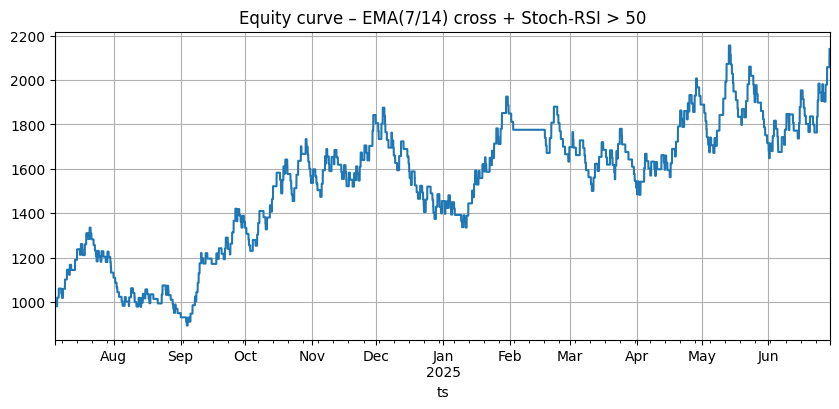

In [41]:
# pip install ccxt pandas numpy matplotlib
import ccxt, pandas as pd, numpy as np, matplotlib.pyplot as plt

# ───────────────── CONFIG ───────────────────────────────────────────
PAIR, TF, LOOKBACK_D = "SOL/USDT", "15m", 360

RISK_PCT     = 0.02      # 2 % equity risk
ATR_MULT_SL  = 2.0       # stop  = 2×ATR14
ATR_MULT_TP  = 4.0       # target= 4×ATR14  (RR = 2:1)
ADX_FLOOR  = 20


# ───────────────── DOWNLOAD DATA ────────────────────────────────────
ex, rows = ccxt.bybit(), []
since = ex.milliseconds() - LOOKBACK_D * 86_400_000
while since < ex.milliseconds():
    chunk = ex.fetch_ohlcv(PAIR, TF, since=since, limit=1000)
    if not chunk: break
    rows.extend(chunk); since = chunk[-1][0] + 1

df = (pd.DataFrame(rows, columns="ts o h l c v".split())
        .assign(ts=lambda d: pd.to_datetime(d.ts, unit="ms", utc=True))
        .set_index("ts"))

# ───────────────── INDICATORS ───────────────────────────────────────
# EMAs
df["ema7"]  = df.c.ewm(span=7).mean()
df["ema14"] = df.c.ewm(span=14).mean()

# ATR14
tr  = np.maximum.reduce([df.h - df.l,
                         (df.h - df.c.shift()).abs(),
                         (df.l - df.c.shift()).abs()])
df["atr"] = pd.Series(tr, index=df.index).rolling(14).mean()

# RSI(14)
delta = df.c.diff()
gain  = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
loss  = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
rs    = gain / loss
df["rsi"] = 100 - 100/(1+rs)

# Stoch-RSI 14,3,3
rsi_min = df.rsi.rolling(14).min()
rsi_max = df.rsi.rolling(14).max()
stoch_rsi = (df.rsi - rsi_min) / (rsi_max - rsi_min)
k_fast = stoch_rsi.rolling(3).mean() * 100           # %K
d_slow = k_fast.rolling(3).mean()                    # %D (not used here)
df["k_fast"] = k_fast

# ADX
plus_dm  = np.where(df.h.diff()>df.l.diff(), df.h.diff().clip(lower=0), 0)
minus_dm = np.where(df.l.diff()>df.h.diff(), df.l.diff().abs(), 0)
tr_n     = pd.Series(tr,index=df.index).rolling(14).sum()
plus_di  = 100*pd.Series(plus_dm,index=df.index).rolling(14).sum()/tr_n
minus_di = 100*pd.Series(minus_dm,index=df.index).rolling(14).sum()/tr_n
dx       = 100*(plus_di-minus_di).abs()/(plus_di+minus_di)
df["adx"] = dx.rolling(14).mean()


# EMA-cross detector
cross_up = (df.ema7 > df.ema14) & (df.ema7.shift() <= df.ema14.shift())
# df["long_signal"] = cross_up & (df.k_fast > 45) & (df.k_fast < 80) & (df.rsi > 50)

df["long_signal"] = cross_up & (df.k_fast > 45)  & (df.rsi > 50)

# ───────────────── SIMPLE BACK-TEST ────────────────────────────────
equity, curve = 1_000.0, []
pos = None
trades = []

for idx, bar in df.iterrows():

    # -------- manage open trade --------
    if pos:
        hit_sl = bar.l <= pos["sl"]
        hit_tp = bar.h >= pos["tp"]

        if hit_sl or hit_tp:
            pnl = -pos["risk"] if hit_sl else pos["risk"] * (ATR_MULT_TP/ATR_MULT_SL)
            equity += pnl
            trades.append({"exit": idx, "pnl": pnl})
            pos = None
         # take half at +1 R
        elif not pos['half'] and (bar.c-pos['entry'])>=pos['risk']:
            equity+=0.5*pos['risk']; pos['half']=True
        # trail remainder
        if pos and pos['half']:
            new_sl = bar.c - ATR_MULT_SL * bar.atr
            if new_sl > pos["sl"]:
                pos["sl"] = new_sl
           

    # -------- new entry --------
    if pos is None and bar.long_signal and  bar.adx>=ADX_FLOOR :
        stop_dist = ATR_MULT_SL * bar.atr
        if stop_dist > 0:
            risk_per_unit = equity * RISK_PCT
            pos = dict(entry=bar.c,
                       sl   = bar.c - stop_dist,
                       tp   = bar.c + ATR_MULT_TP * bar.atr,
                       risk = risk_per_unit,
                        half=False)


    curve.append(equity)

# ───────────────── RESULTS ─────────────────────────────────────────
eq_series = pd.Series(curve, index=df.index[-len(curve):])
wins = sum(1 for t in trades if t["pnl"] > 0)
print(f"Trades: {len(trades)}  |  Wins: {wins}  |  Win-rate: {wins/len(trades):.1%}")
print(f"Final balance: ${equity:,.0f}  |  Max DD: {100*(min(eq_series)-1_000)/1_000:.1f}%")

eq_series.plot(title="Equity curve – EMA(7/14) cross + Stoch-RSI > 50", figsize=(10,4), grid=True)
plt.show()
